## Problem Statement:
## Predict how much could be the insurance charges for a beneficiary based on the data provided using Linear Regression


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warningss
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Descriptive stat

In [3]:
des = data.describe()

In [4]:
des.loc[['mean','50%'],:]

,age,bmi,children,charges
mean,39.207025,30.663397,1.094918,13270.422265
50%,39.000000,30.400000,1.000000,9382.033000


In [5]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
data.shape

(1338, 7)

# EDA

In [8]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
num_col = data[['age','bmi','charges']]
cat_col = data[['sex','children','smoker','region']]

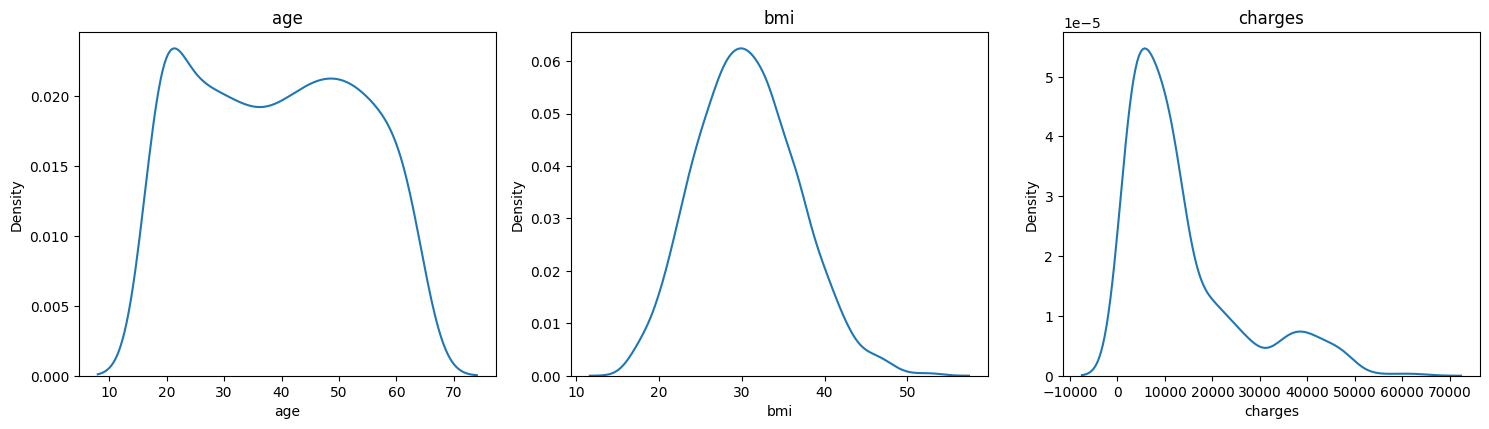

In [10]:
plt.figure(figsize=(15,12))
for i,j in enumerate(num_col.columns,1):
    plt.subplot(3,3,i)
    sns.kdeplot(num_col[j])
    plt.title(j)

plt.tight_layout()
plt.show()


- create age group
- handle skewness in charges

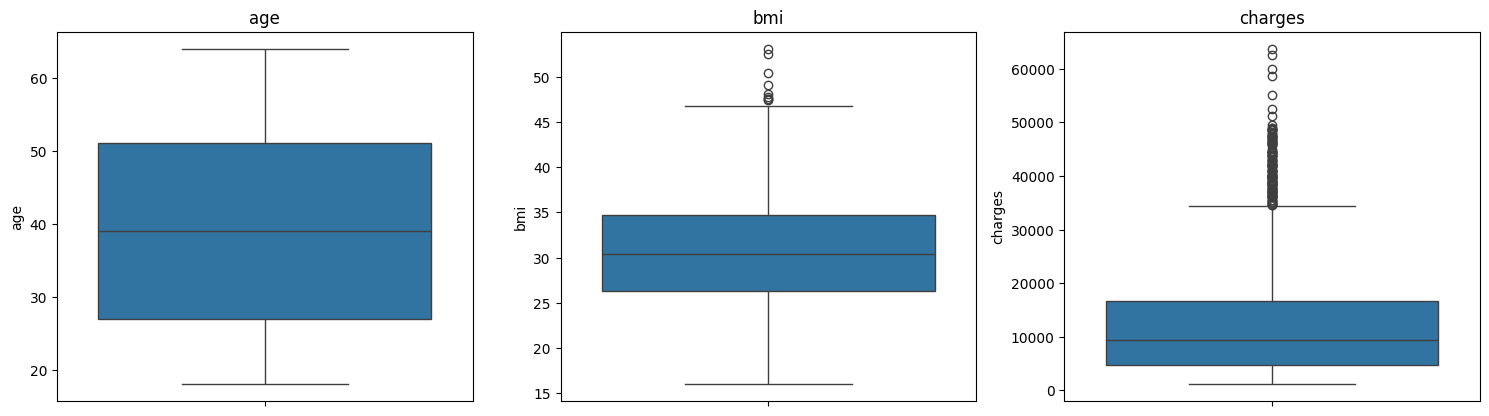

In [11]:
plt.figure(figsize=(15,12))
for i,j in enumerate(num_col.columns,1):
    plt.subplot(3,3,i)
    sns.boxplot(num_col[j])
    plt.title(j)

plt.tight_layout()
plt.show()


- cap outliers in bmi
- cap outliers in charges

<Axes: xlabel='bmi', ylabel='charges'>

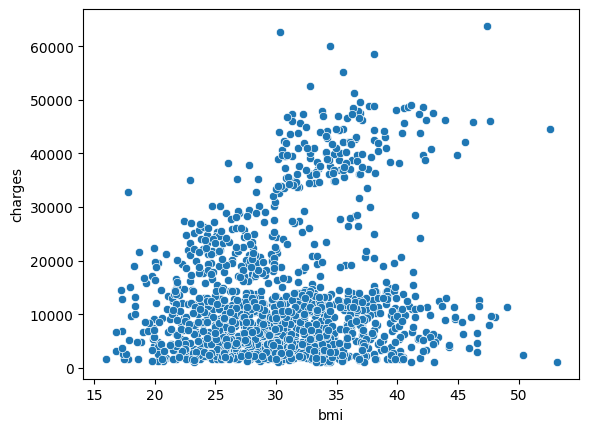

In [12]:
sns.scatterplot(x='bmi',y='charges',data=data)

- sort of linear relationship with bmi

<Axes: xlabel='age', ylabel='charges'>

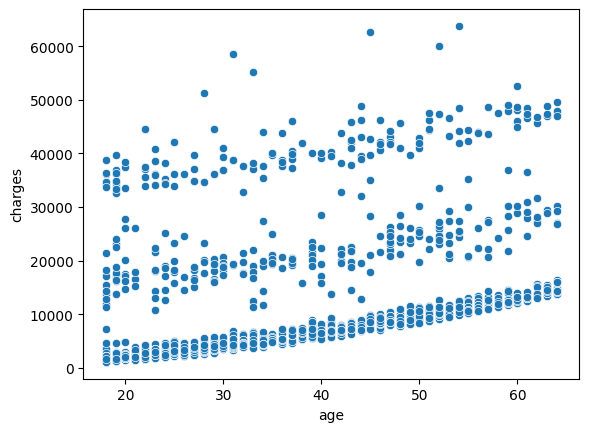

In [13]:
sns.scatterplot(x='age',y='charges',data=data)

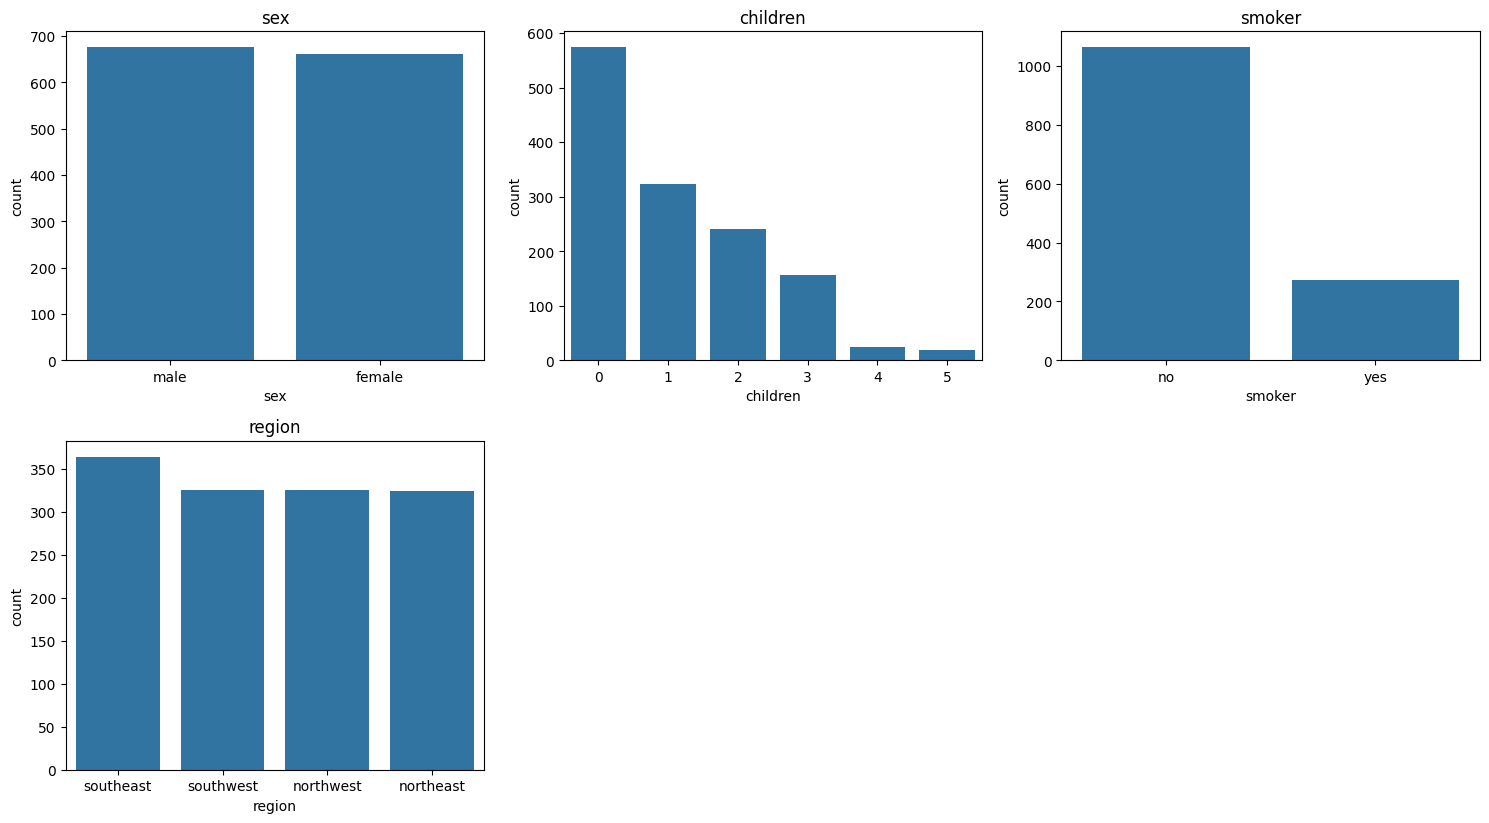

In [14]:
plt.figure(figsize=(15,12))
for i,j in enumerate(cat_col.columns,1):
    plt.subplot(3,3,i)
    sns.barplot(cat_col[j].value_counts())
    plt.title(j)

plt.tight_layout()
plt.show()


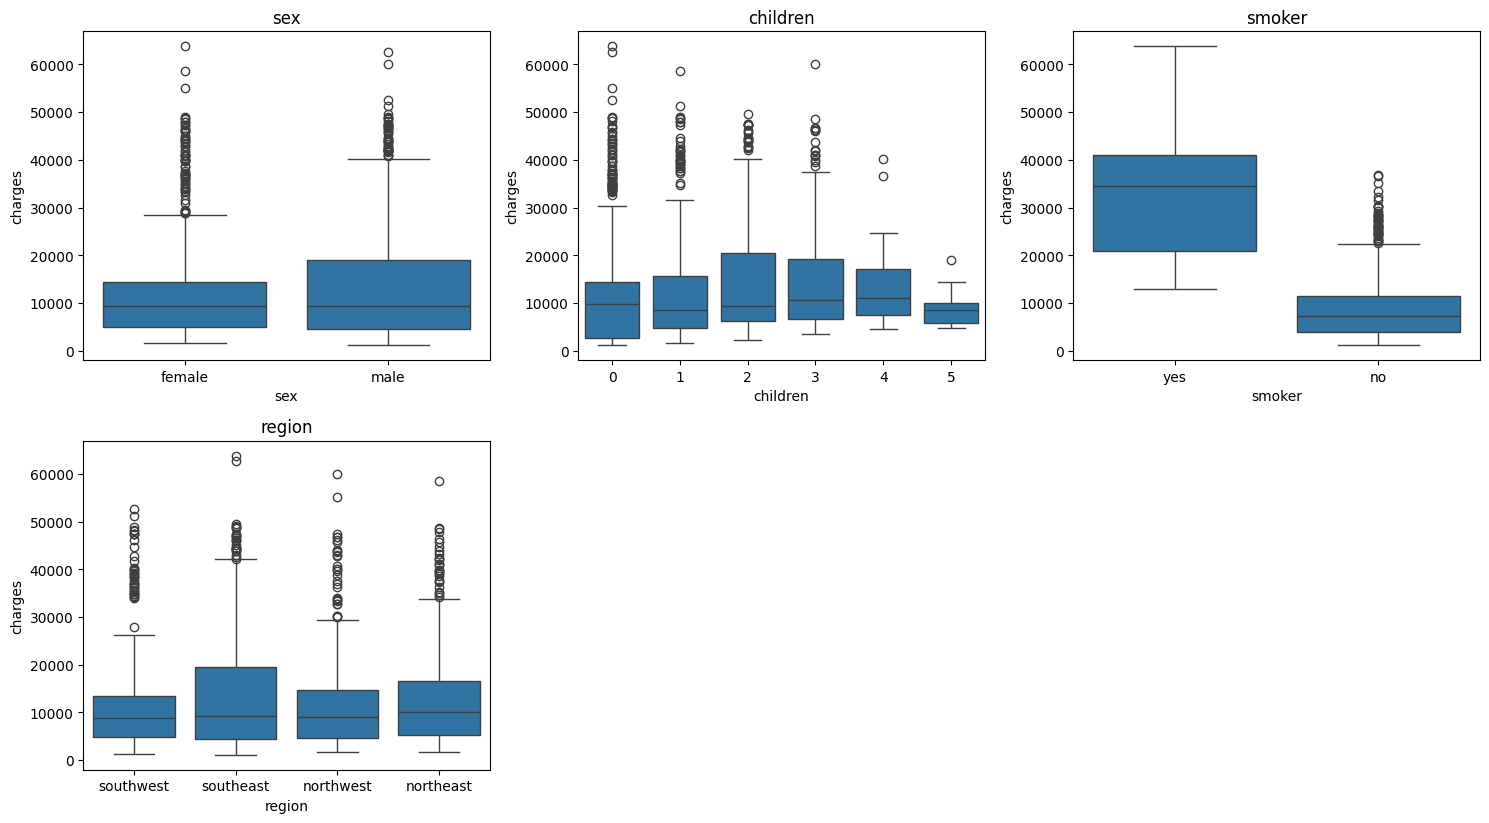

In [15]:
plt.figure(figsize=(15,12))
for i,j in enumerate(cat_col.columns,1):
    plt.subplot(3,3,i)
    sns.boxplot(x=j,y='charges',data=data)
    plt.title(j)

plt.tight_layout()
plt.show()


- Smoker status is the strongest factor impacting charges.
- The number of children does not appear to heavily influence charges.
- Gender and region do not have a strong effect on the distribution of charges,

<Axes: xlabel='region', ylabel='charges'>

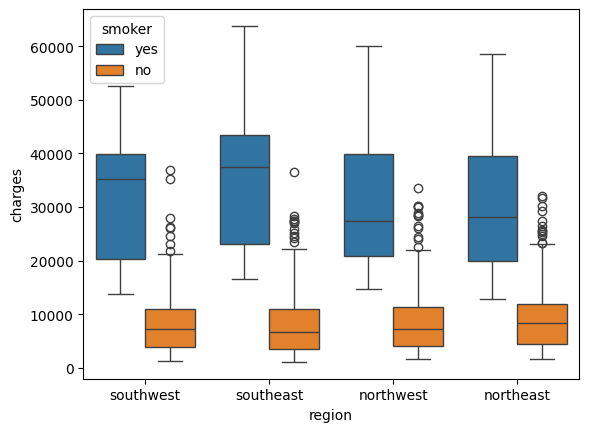

In [16]:
sns.boxplot(x='region', y='charges', hue='smoker', data=data)

- Smokers across all regions have significantly higher medical expenses
- Southeast region appears to have the highest number of extreme outliers

# creating new age column

In [17]:
bins = [0, 18, 35, 55, np.inf]
labels = ['Young', 'Adult', 'Middle-aged', 'Senior']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)

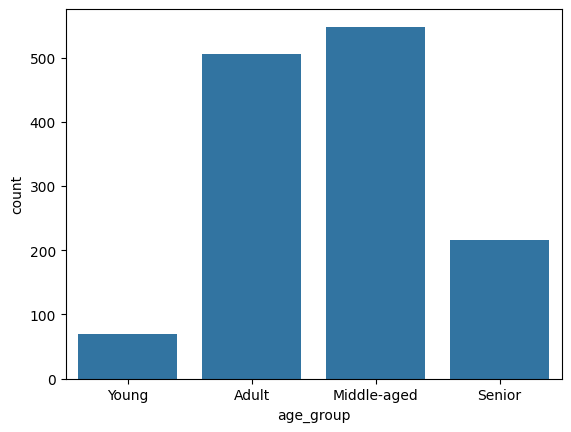

In [18]:
sns.barplot(data['age_group'].value_counts())
plt.show()

# capping outliers

In [19]:
from scipy.stats.mstats import winsorize
data['bmi_cap'] = winsorize(data['bmi'],limits=[0.01,0.01])
data['charge_cap'] = winsorize(data['charges'],limits=[0.01,0.01])

# transformation

In [21]:
data['charge_cap'] = np.cbrt(data['charge_cap'])

<Axes: xlabel='charge_cap', ylabel='Density'>

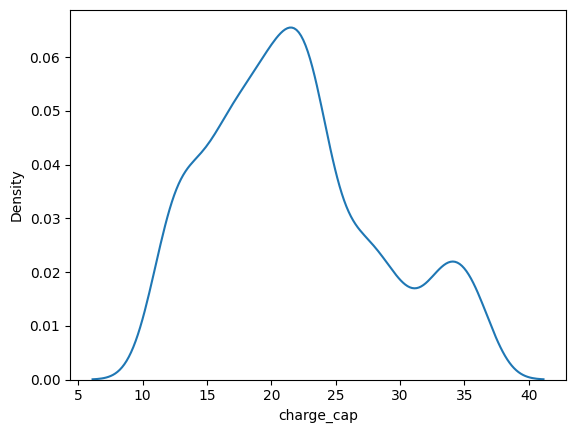

In [22]:
sns.kdeplot(data['charge_cap'])

# Encoding

In [23]:
sex_replace = {
    'male' : 1,
    'female' : 0
}

smoker_replace = {
    'yes' : 1,
    'no' : 0
}

data['sex_encode'] = data['sex'].replace(sex_replace)

In [24]:
data['smoker_encode'] = data['smoker'].replace(smoker_replace)

In [25]:
from sklearn.preprocessing import OrdinalEncoder

age_groups = ['Young', 'Adult', 'Middle-aged', 'Senior']
ord_encode = OrdinalEncoder(categories=[age_groups])
data['age_group_encoded'] = ord_encode.fit_transform(data[['age_group']])


In [26]:
data_new = data[['age_group_encoded','sex_encode','bmi_cap','children','smoker_encode','region','charge_cap']]

In [27]:
data_encoded = pd.get_dummies(data_new,columns=['region'],drop_first=True)

In [28]:
data_encoded.head()

,age_group_encoded,sex_encode,bmi_cap,children,smoker_encode,charge_cap,region_northwest,region_southeast,region_southwest
0,1.0,0,27.900,0,1,25.654666,False,False,True
1,0.0,1,33.770,1,0,11.994331,False,True,False
2,1.0,1,33.000,3,0,16.447599,False,True,False
3,1.0,1,22.705,0,0,28.013799,True,False,False
4,1.0,1,28.880,0,0,15.695891,True,False,False


# feature importance

In [29]:
# random forest method
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

x = data_encoded.drop(columns=['charge_cap'])
y = data_encoded['charge_cap']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
model = RandomForestRegressor(n_estimators=100,random_state=42)

model.fit(x_train,y_train)

important = model.feature_importances_

df = pd.DataFrame(
    {
        'feature': x.columns,
        'importance': important
    }
)
df.sort_values(by='importance',ascending=False)

,feature,importance
4,smoker_encode,0.530110
0,age_group_encoded,0.198894
2,bmi_cap,0.188277
3,children,0.041623
1,sex_encode,0.012900
6,region_southeast,0.010624
7,region_southwest,0.009408
5,region_northwest,0.008163


In [30]:
# rfe method
from sklearn.feature_selection import RFE

rfe = RFE(estimator=model,n_features_to_select=5)
rfe.fit(x_train,y_train)

rank = rfe.ranking_

df = pd.DataFrame({
    'feature': x.columns,
    'ranking' : rank
}).sort_values(by='ranking',ascending=False)

In [31]:
df # (1 means the feature is selected)

,feature,ranking
5,region_northwest,4
7,region_southwest,3
6,region_southeast,2
0,age_group_encoded,1
1,sex_encode,1
2,bmi_cap,1
3,children,1
4,smoker_encode,1


# feature scaling

In [32]:
from sklearn.preprocessing import StandardScaler
data_encoded_copy = data_encoded.copy()

features_to_scale = ['bmi_cap', 'children']
scaler = StandardScaler()
data_encoded_copy[features_to_scale] = scaler.fit_transform(data_encoded_copy[features_to_scale])

# model building

In [33]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score

X = data_encoded_copy[['age_group_encoded','sex_encode','bmi_cap','children','smoker_encode']]
y = data_encoded_copy['charge_cap']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
selected_features = ['age_group_encoded', 'sex_encode', 'bmi_cap', 'children', 'smoker_encode']
formula = 'charge_cap ~ ' + ' + '.join(selected_features)

In [35]:
model = smf.ols(formula=formula,data=data_encoded_copy).fit()

In [36]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 9.759214470096527
R-squared: 0.7877560652449288


# Multicolinerity check

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df = pd.DataFrame()
df['feature'] = X.columns
df['vif_score'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]

df

,feature,vif_score
0,age_group_encoded,1.777168
1,sex_encode,1.722788
2,bmi_cap,1.001715
3,children,1.000335
4,smoker_encode,1.226075


# tunning parameters

In [38]:
# ridge regression

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
param = {'alpha':[0.1,1.0,10.0,100.0]}

ridge_cv = GridSearchCV(ridge,param,cv=5,scoring='r2')
ridge_cv.fit(X_train,y_train)

y_pred_cv = ridge_cv.predict(X_test)
r2_score = r2_score(y_test,y_pred_cv)
print(r2_score)



0.7841602514326218


# cooks distance (removing influential points)

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_final = data_encoded_copy[['age_group_encoded','sex_encode','bmi_cap','children','smoker_encode','charge_cap']]
threshold = 4 / len(data_final)

for i in range(80):
    model_cleaned = smf.ols(formula=formula,data=data_final).fit()
    c,_ = model_cleaned.get_influence().cooks_distance
    influence = np.argmax(c)
    if c[influence] > threshold:
        data_final = data_final.drop(data_final.index[influence],axis=0)
    else:
        break
        
model_cleaned = smf.ols(formula=formula,data=data_final).fit()
r_sq = model_cleaned.rsquared

print(r_sq)
    

0.8706032274964256


In [42]:
y_pred = model_cleaned.predict(X_test)

# residuals plot

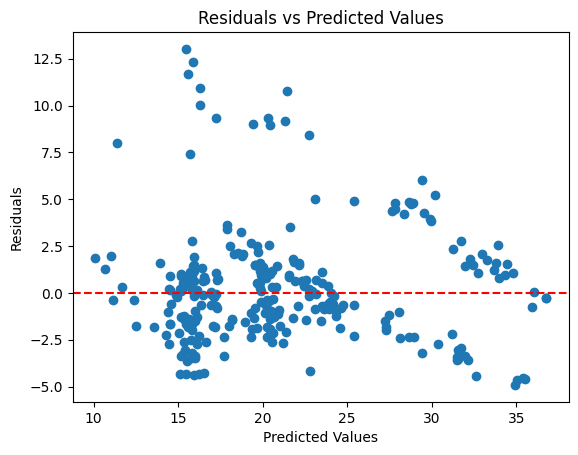

In [43]:
residuals = y_test - y_pred
import matplotlib.pyplot as plt

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


- mostly points are scattered around zero
- there are some outliers . as the Residual spread widens slightly as predicted values increase